In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
from six import StringIO
from IPython.display import Image
import graphviz
import dtreeviz
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer, MinMaxScaler, KBinsDiscretizer, PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.tree import plot_tree

In [3]:
DATA_DIR = '../output'

# Decision Trees
**Vorüberlegungen:**   
Ab 2011 sinkt die EEG-Einspeisevergütung unter den Haushaltsstrompreis.      
Dadurch lohnt sich das Einspeisen von Strom finanziell nicht mehr.   
Seitdem ist die Einspeisevergütung weiter gesunken, während die Strompreise deutlich gestiegen sind.    
Daher sehen wir ab 2011 größtenteils Teileinspeiser, die sen erzeugten Strom also zuerst selbst verbrauchen.   
Dieser Zeitraum soll untersucht werden. 
   
**Zielvariable:**    
Anzahl der installierten PV-Anlagen pro Gemeinde (ALG-8)    

## Import 

In [4]:
solar_raw = pd.read_csv(os.path.join(DATA_DIR, 'marktstd_full.csv'))
pd.set_option('display.max_columns', 130)
#solar_raw.head(5)

In [5]:
# Einträge vor dem 01.01.2011 löschen
solar_df = solar_raw[solar_raw['Inbetriebnahmedatum'] >= '2011-01-01']
solar_df.head(3)

,DatumLetzteAktualisierung,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Bundesland,Landkreis,Gemeinde,AGS-8,Postleitzahl,Ort,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Bruttoleistung,FernsteuerbarkeitNb,Einspeisungsart,ZugeordneteWirkleistungWechselrichter,GemeinsamerWechselrichterMitSpeicher,AnzahlModule,Lage,Leistungsbegrenzung,EinheitlicheAusrichtungUndNeigungswinkel,Hauptausrichtung,HauptausrichtungNeigungswinkel,Nutzungsbereich,AGS-5,Inbetriebnahmejahr,Fläche km2,Bevölkerung,Bevölkerung pro km2,Bev_Entwicklung_%,Eigentum_%,Gini_Index,haushaltseink_1995,haushaltseink_1996,haushaltseink_1997,haushaltseink_1998,haushaltseink_1999,haushaltseink_2000,haushaltseink_2001,haushaltseink_2002,haushaltseink_2003,haushaltseink_2004,haushaltseink_2005,haushaltseink_2006,haushaltseink_2007,haushaltseink_2008,haushaltseink_2009,haushaltseink_2010,haushaltseink_2011,haushaltseink_2012,haushaltseink_2013,haushaltseink_2014,haushaltseink_2015,haushaltseink_2016,haushaltseink_2017,haushaltseink_2018,haushaltseink_2019,haushaltseink_2020,BIP,Arbeitslosenquote_%,Unter 3 Jahre,3 bis 5 Jahre,6 bis 9 Jahre,10 bis 15 Jahre,16 bis 18 Jahre,19 bis 24 Jahre,25 bis 39 Jahre,40 bis 59 Jahre,60 bis 66 Jahre,67 bis 74 Jahre,75 Jahre und älter,Deutsche mit beidseitigem Migrationshintergrund_Prozent,Deutsche mit einseitigem Migrationshintergrund_Prozent,Ausländer/-innen mit eigener Migrationserfahrung_Prozent,Ausländer/-innen ohne eigene Migrationserfahrung_Prozent,Deutsche mit eigener Migrationserfahrung_Prozent,Deutsche ohne eigene Migrationserfahrung_Prozent,Ausländer/-innen_Prozent,Deutsche mit Migrationshintergrund_Prozent,Personen mit Migrationshintergrund_Prozent,Personen ohne Migrationshintergrund_Prozent,Ledig_Prozent,Verheiratet/Eingetr. Lebenspartnerschaft_Prozent,Geschieden/Eingetr. Lebenspartnerschaft aufgehoben_Prozent,Verwitwet/Eingetr. Lebenspartner/-in verstorben_Prozent,Ohne Angabe_Prozent,bquali_unifh,bquali_mabschl,bquali_oabschl,schule_oabschl,Auslaender_%,Straftaten,Einbruch,CDU_Prozent,SPD_Prozent,AfD_Prozent,FDP_Prozent,DIE LINKE_Prozent,GRÜNE_Prozent,CSU_Prozent,FREIE WÄHLER_Prozent,Die PARTEI_Prozent,Tierschutzpartei_Prozent,NPD_Prozent,PIRATEN_Prozent,Sonnenstunden,eLade,eAuto,Wohnen_EZFH,Wohnen_MFH,Heizung_Erneuerbare_%,Strom_Verbraucherpreis,Einspeiseverguetung_kleine_PV_Anlagen
1,2021-07-15 07:54:37.863709,1,ABR930055871044,Baden-Württemberg,Ostalbkreis,Schwäbisch Gmünd,8136065,73529,Schwäbisch Gmünd,2019-01-31 00:00:00,2013-01-31 00:00:00,In Betrieb,7.41,0.0,Teileinspeisung (einschließlich Eigenverbrauch),8.3,Kein Stromspeicher vorhanden,42,"Bauliche Anlagen (Hausdach, Gebäude und Fassade)","Ja, auf 70%",1.0,Süd,20 - 40 Grad,Haushalt,8136,2013,1511.39,315009.0,208.0,0.33,57.1,0.29,14456,14527,14839,15084,15478,15721,16583,16635,17103,17473,17979,18657,19213,19708,19325,19952,20878,21520,21920,22706,22772,23336,24031,25288,25642,25425,82.54,3.5,2.4,2.7,3.8,6.4,3.6,7.7,17.6,29.1,7.6,9.1,10.1,6.38,2.66,9.27,2.86,13.90,9.06,12.13,22.94,35.09,64.93,39.810001,46.509998,6.18,7.49,0.01,15.81,66.12,12.91,6.11,11.65,3225.32,27.04,31.061302,26.112497,10.229063,10.494881,3.409688,13.028354,0.000000,1.693358,1.850879,0.0,0.0,0.000000,1717.6,102.54,1.18,18.835867,18.0,61.7,30.46,11.31
2,2019-05-28 08:26:38.031669,1,ABR983885950021,Brandenburg,Havelland,Nauen,12063208,14641,Nauen,2019-01-31 00:00:00,2016-02-19 00:00:00,In Betrieb,5.04,0.0,Teileinspeisung (einschließlich Eigenverbrauch),5.0,Stromspeicher vorhanden - kein gemeinsamer Wec...,22,"Bauliche Anlagen (Hausdach, Gebäude und Fassade)","Ja, auf 70%",1.0,Süd,20 - 40 Grad,Haushalt,12063,2016,1727.31,165906.0,96.0,1.63,56.7,0.26,12074,12761,12949,13131,13516,13789,14336,14365,14546,14756,15113,15668,16126,16539,17013,17163,17701,17828,18276,18721,18970,19418,20519,21378,21985,22437,59.75,5.6,2.9,2.2,3.3,4.3,1.9,7.8,18.2,33.4,6.4,10.1,9.5,0.00,0.00,0.98,0.00,1.41,0.92,1.53,2.33,3.87,96.13,41.840000,42.450001,7.65,8.06,0.00,9.97,68.99,9.81,4.02,5.30,5250.37,7

## Datenintegration   
Als Zielvariable wird die Anzahl der installierten PV-Anlagen pro Gemeinde (ALG-8) festgelegt.

In [6]:
# Erstellen der Zielvariable: target_col
target_col = solar_df.groupby("AGS-8")["AnlagenbetreiberMastrNummer"].count().reset_index()
target_col.columns = ["AGS-8", "Anzahl_PV_Anlagen"]
# Merge mit Marktstammdaten
solar_df = solar_df.merge(target_col, on="AGS-8", how="left")
solar_df.head(3)

,DatumLetzteAktualisierung,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Bundesland,Landkreis,Gemeinde,AGS-8,Postleitzahl,Ort,Registrierungsdatum,Inbetriebnahmedatum,EinheitBetriebsstatus,Bruttoleistung,FernsteuerbarkeitNb,Einspeisungsart,ZugeordneteWirkleistungWechselrichter,GemeinsamerWechselrichterMitSpeicher,AnzahlModule,Lage,Leistungsbegrenzung,EinheitlicheAusrichtungUndNeigungswinkel,Hauptausrichtung,HauptausrichtungNeigungswinkel,Nutzungsbereich,AGS-5,Inbetriebnahmejahr,Fläche km2,Bevölkerung,Bevölkerung pro km2,Bev_Entwicklung_%,Eigentum_%,Gini_Index,haushaltseink_1995,haushaltseink_1996,haushaltseink_1997,haushaltseink_1998,haushaltseink_1999,haushaltseink_2000,haushaltseink_2001,haushaltseink_2002,haushaltseink_2003,haushaltseink_2004,haushaltseink_2005,haushaltseink_2006,haushaltseink_2007,haushaltseink_2008,haushaltseink_2009,haushaltseink_2010,haushaltseink_2011,haushaltseink_2012,haushaltseink_2013,haushaltseink_2014,haushaltseink_2015,haushaltseink_2016,haushaltseink_2017,haushaltseink_2018,haushaltseink_2019,haushaltseink_2020,BIP,Arbeitslosenquote_%,Unter 3 Jahre,3 bis 5 Jahre,6 bis 9 Jahre,10 bis 15 Jahre,16 bis 18 Jahre,19 bis 24 Jahre,25 bis 39 Jahre,40 bis 59 Jahre,60 bis 66 Jahre,67 bis 74 Jahre,75 Jahre und älter,Deutsche mit beidseitigem Migrationshintergrund_Prozent,Deutsche mit einseitigem Migrationshintergrund_Prozent,Ausländer/-innen mit eigener Migrationserfahrung_Prozent,Ausländer/-innen ohne eigene Migrationserfahrung_Prozent,Deutsche mit eigener Migrationserfahrung_Prozent,Deutsche ohne eigene Migrationserfahrung_Prozent,Ausländer/-innen_Prozent,Deutsche mit Migrationshintergrund_Prozent,Personen mit Migrationshintergrund_Prozent,Personen ohne Migrationshintergrund_Prozent,Ledig_Prozent,Verheiratet/Eingetr. Lebenspartnerschaft_Prozent,Geschieden/Eingetr. Lebenspartnerschaft aufgehoben_Prozent,Verwitwet/Eingetr. Lebenspartner/-in verstorben_Prozent,Ohne Angabe_Prozent,bquali_unifh,bquali_mabschl,bquali_oabschl,schule_oabschl,Auslaender_%,Straftaten,Einbruch,CDU_Prozent,SPD_Prozent,AfD_Prozent,FDP_Prozent,DIE LINKE_Prozent,GRÜNE_Prozent,CSU_Prozent,FREIE WÄHLER_Prozent,Die PARTEI_Prozent,Tierschutzpartei_Prozent,NPD_Prozent,PIRATEN_Prozent,Sonnenstunden,eLade,eAuto,Wohnen_EZFH,Wohnen_MFH,Heizung_Erneuerbare_%,Strom_Verbraucherpreis,Einspeiseverguetung_kleine_PV_Anlagen,Anzahl_PV_Anlagen
0,2021-07-15 07:54:37.863709,1,ABR930055871044,Baden-Württemberg,Ostalbkreis,Schwäbisch Gmünd,8136065,73529,Schwäbisch Gmünd,2019-01-31 00:00:00,2013-01-31 00:00:00,In Betrieb,7.41,0.0,Teileinspeisung (einschließlich Eigenverbrauch),8.3,Kein Stromspeicher vorhanden,42,"Bauliche Anlagen (Hausdach, Gebäude und Fassade)","Ja, auf 70%",1.0,Süd,20 - 40 Grad,Haushalt,8136,2013,1511.39,315009.0,208.0,0.33,57.1,0.29,14456,14527,14839,15084,15478,15721,16583,16635,17103,17473,17979,18657,19213,19708,19325,19952,20878,21520,21920,22706,22772,23336,24031,25288,25642,25425,82.54,3.5,2.4,2.7,3.8,6.4,3.6,7.7,17.6,29.1,7.6,9.1,10.1,6.38,2.66,9.27,2.86,13.90,9.06,12.13,22.94,35.09,64.93,39.810001,46.509998,6.18,7.49,0.01,15.81,66.12,12.91,6.11,11.65,3225.32,27.04,31.061302,26.112497,10.229063,10.494881,3.409688,13.028354,0.000000,1.693358,1.850879,0.0,0.0,0.000000,1717.6,102.54,1.18,18.835867,18.0,61.7,30.46,11.31,1611
1,2019-05-28 08:26:38.031669,1,ABR983885950021,Brandenburg,Havelland,Nauen,12063208,14641,Nauen,2019-01-31 00:00:00,2016-02-19 00:00:00,In Betrieb,5.04,0.0,Teileinspeisung (einschließlich Eigenverbrauch),5.0,Stromspeicher vorhanden - kein gemeinsamer Wec...,22,"Bauliche Anlagen (Hausdach, Gebäude und Fassade)","Ja, auf 70%",1.0,Süd,20 - 40 Grad,Haushalt,12063,2016,1727.31,165906.0,96.0,1.63,56.7,0.26,12074,12761,12949,13131,13516,13789,14336,14365,14546,14756,15113,15668,16126,16539,17013,17163,17701,17828,18276,18721,18970,19418,20519,21378,21985,22437,59.75,5.6,2.9,2.2,3.3,4.3,1.9,7.8,18.2,33.4,6.4,10.1,9.5,0.00,0.00,0.98,0.00,1.41,0.92,1.53,2.33,3.87,96.13,41.840000,42.450001,7.65,8.06,0.00,9.97,68.99,9

In [7]:
solar_df.isna().sum()

DatumLetzteAktualisierung                0
NetzbetreiberpruefungStatus              0
AnlagenbetreiberMastrNummer              0
Bundesland                               0
Landkreis                                0
                                        ..
Wohnen_MFH                               0
Heizung_Erneuerbare_%                    0
Strom_Verbraucherpreis                   0
Einspeiseverguetung_kleine_PV_Anlagen    0
Anzahl_PV_Anlagen                        0
Length: 114, dtype: int64

Splitten der Daten in Trainings-und Testdaten

In [8]:
df_train, df_test = train_test_split(solar_df, test_size=0.2, random_state=42)

In [9]:
print(df_train.shape)

(1834804, 114)


In [10]:
print(df_test.shape)

(458702, 114)


## Transformation

In [11]:
# Unterteilung der Spalten in Zielvariable, numerische und kategoriale Werte

target_var = "Anzahl_PV_Anlagen"

num_vars = ["Bruttoleistung", "AnzahlModule", "Bevölkerung pro km2", "Bev_Entwicklung_%", "Eigentum_%", 
                  "Gini_Index", "haushaltseink_2011", "haushaltseink_2020", "BIP", "Arbeitslosenquote_%",
                  "Unter 3 Jahre", "3 bis 5 Jahre", "6 bis 9 Jahre", "10 bis 15 Jahre", "16 bis 18 Jahre",
                  "19 bis 24 Jahre", "25 bis 39 Jahre", "40 bis 59 Jahre", "60 bis 66 Jahre", "75 Jahre und älter",
                  "Personen mit Migrationshintergrund_Prozent", "Personen ohne Migrationshintergrund_Prozent", 
                  "Auslaender_%", "Ledig_Prozent", "Verheiratet/Eingetr. Lebenspartnerschaft_Prozent",
                  "Geschieden/Eingetr. Lebenspartnerschaft aufgehoben_Prozent",
                  "Verwitwet/Eingetr. Lebenspartner/-in verstorben_Prozent", "bquali_unifh", "bquali_mabschl", 
                  "bquali_oabschl", "schule_oabschl", "Straftaten", "Einbruch", "CDU_Prozent", "CDU_Prozent",
                  "AfD_Prozent", "FDP_Prozent", "GRÜNE_Prozent", "FREIE WÄHLER_Prozent", "CDU_Prozent", "CDU_Prozent",
                  "Sonnenstunden", "eLade", "eAuto", "Wohnen_EZFH", "Wohnen_MFH", "Heizung_Erneuerbare_%",
                 ]

cat_vars = ["AGS-8", "EinheitBetriebsstatus", "Einspeisungsart", "Hauptausrichtung",
                 "Nutzungsbereich"                 
                 ]

In [12]:
# Verteilungsschema der kategorialen Daten 
df_train[cat_vars].apply(lambda x: len(x.unique()))

AGS-8                    11059
EinheitBetriebsstatus        4
Einspeisungsart              2
Hauptausrichtung            10
Nutzungsbereich              6
dtype: int64

## PCA Test

In [13]:
# Sample mit 20.000 Zeilen ziehen
sample_df = df_train.sample(20000, random_state=42)

In [14]:
pca_prepare = ColumnTransformer([
    ("pca", Pipeline([
        ("std", StandardScaler()),
        ("pca", PCA(n_components=5))
    ]), num_vars)
])

In [15]:
pca_data = pd.DataFrame(pca_prepare.fit_transform(sample_df))

In [16]:
demo = sample_df.copy()

In [17]:
demo = demo.reset_index().merge(pca_data, left_index=True, right_index=True)

In [18]:
pca_data

,0,1,2,3,4
0,1.613743,0.337352,2.711010,-1.918844,0.800023
1,-0.651786,-1.303619,2.088764,-0.040362,0.820380
2,-6.092113,2.716451,-2.342300,0.951966,0.838369
3,1.509664,0.175502,2.725348,-0.998892,-0.470692
4,-5.236044,1.070879,-2.137834,1.974105,3.545030
...,...,...,...,...,...
19995,-0.605879,-1.693220,3.395154,0.611706,0.957607
19996,-0.851928,-0.950208,5.190213,1.765123,1.164994
19997,0.768294,-3.819876,-2.202988,0.422092,-1.837635
19998,-0.577289,-0.315870,-0.054873,0.693886,1.183593


## Korrrelationen

In [19]:
corr = sample_df[num_vars + [target_var]].corr()
corr

,Bruttoleistung,AnzahlModule,Bevölkerung pro km2,Bev_Entwicklung_%,Eigentum_%,Gini_Index,haushaltseink_2011,haushaltseink_2020,BIP,Arbeitslosenquote_%,Unter 3 Jahre,3 bis 5 Jahre,6 bis 9 Jahre,10 bis 15 Jahre,16 bis 18 Jahre,19 bis 24 Jahre,25 bis 39 Jahre,40 bis 59 Jahre,60 bis 66 Jahre,75 Jahre und älter,Personen mit Migrationshintergrund_Prozent,Personen ohne Migrationshintergrund_Prozent,Auslaender_%,Ledig_Prozent,Verheiratet/Eingetr. Lebenspartnerschaft_Prozent,Geschieden/Eingetr. Lebenspartnerschaft aufgehoben_Prozent,Verwitwet/Eingetr. Lebenspartner/-in verstorben_Prozent,bquali_unifh,bquali_mabschl,bquali_oabschl,schule_oabschl,Straftaten,Einbruch,CDU_Prozent,CDU_Prozent,AfD_Prozent,FDP_Prozent,GRÜNE_Prozent,FREIE WÄHLER_Prozent,CDU_Prozent,CDU_Prozent,Sonnenstunden,eLade,eAuto,Wohnen_EZFH,Wohnen_MFH,Heizung_Erneuerbare_%,Anzahl_PV_Anlagen
Bruttoleistung,1.000000,0.958772,-0.013345,-0.015685,-0.007396,-0.039188,-0.029157,-0.023472,-0.014353,0.014751,-0.000505,-0.007719,-0.021290,-0.026279,-0.024663,-0.000819,-0.002703,0.004911,0.000392,0.020114,-0.025873,0.025846,-0.026941,-0.003582,-0.011987,0.016307,0.023006,-0.011342,0.023902,-0.035108,0.017355,0.004356,0.000048,-0.003278,-0.003278,0.037987,-0.002514,-0.026704,0.002250,-0.003278,-0.003278,0.009266,-0.005486,-0.026876,0.002229,-0.015213,0.001210,-0.010923
AnzahlModule,0.958772,1.000000,-0.015807,-0.023330,-0.007767,-0.045271,-0.034086,-0.028306,-0.017295,0.015013,-0.003611,-0.013409,-0.026783,-0.029319,-0.024857,-0.001157,-0.006681,0.008832,-0.000225,0.024524,-0.031357,0.031318,-0.030894,-0.005587,-0.012234,0.017302,0.027736,-0.012355,0.027934,-0.041100,0.022821,0.007423,0.001219,-0.004786,-0.004786,0.044141,-0.002429,-0.030515,0.002382,-0.004786,-0.004786,0.012778,-0.005285,-0.030770,0.004323,-0.017464,0.000531,-0.012705
Bevölkerung pro km2,-0.013345,-0.015807,1.000000,0.018836,-0.562626,0.208293,0.070852,-0.020655,0.294535,0.251901,0.207304,0.011478,-0.187209,-0.296679,-0.250634,0.224976,0.580104,-0.385474,-0.056855,-0.048512,0.319007,-0.319026,0.617687,0.434904,-0.534135,0.391573,-0.131363,0.695412,-0.698996,0.118085,0.011045,0.622515,0.437969,0.057234,0.057234,-0.209649,0.050913,0.337185,-0.212383,0.057234,0.057234,0.039559,0.012117,0.234112,-0.469877,0.288749,-0.452210,0.821820
Bev_Entwicklung_%,-0.015685,-0.023330,0.018836,1.000000,0.057839,0.156517,0.251898,0.237988,0.202822,-0.266629,0.267906,0.270927,0.265901,0.236653,0.199056,0.120607,0.196067,-0.068988,-0.192683,-0.355629,0.209452,-0.209265,0.208416,0.249665,-0.060234,-0.089180,-0.378536,0.066608,-0.170787,0.167716,-0.223841,-0.131987,-0.163340,-0.115213,-0.115213,-0.240420,0.107811,0.182781,0.158238,-0.115213,-0.115213,0.249582,0.147964,0.234863,0.309649,0.306379,-0.041444,0.045005
Eigentum_%,-0.007396,-0.007767,-0.562626,0.057839,1.000000,0.191846,0.010104,0.065734,-0.178374,-0.181381,-0.134891,0.105364,0.406856,0.590549,0.543256,-0.259240,-0.523212,0.559286,-0.109625,-0.274640,-0.188122,0.188209,-0.346262,-0.321835,0.663515,-0.715035,-0.131820,-0.557701,0.398797,0.156551,-0.132939,-0.500328,-0.247780,0.023010,0.023010,-0.048830,-0.108126,-0.339796,0.295162,0.023010,0.023010,-0.172704,-0.029783,-0.100007,0.501311,-0.174006,0.347505,-0.479943
Gini_Index,-0.039188,-0.045271,0.208293,0.156517,0.191846,1.000000,0.390689,0.296499,0.220152,-0.020590,0.048223,0.163977,0.329301,0.523550,0.605367,0.111911,0.023448,-0.169086,-0.160793,-0.244072,0.485159,-0.485013,0.470741,0.123635,0.085631,-0.229793,-0.282006,0.068591,-0.420182,0.716599,-0.495245,-0.080477,0.142309,0.047471,0.047471,-0.755865,-0.031408,0.336310,0.028543,0.047471,0.047471,-0.342414,0.130781,0.436868,0.009394,0.195557,-0.002516,0.213903
haushaltseink_2011,-0.029157,-0.034086,0.070852,0.251898,0.010104,0.390689,1.000000,0.934120,0.526511,-0.497833,0.165731,0.250639,0.280545,0.332070,0.330203,-0.030434,0.055426,-0.070498,-0.097343,-0.275543,0.426245,-0.426020,0.461990,0.123026,0.118202,-0.179946,-0.426933,0.350434,-0.417214,0.297389,-0.408940,-0.38396

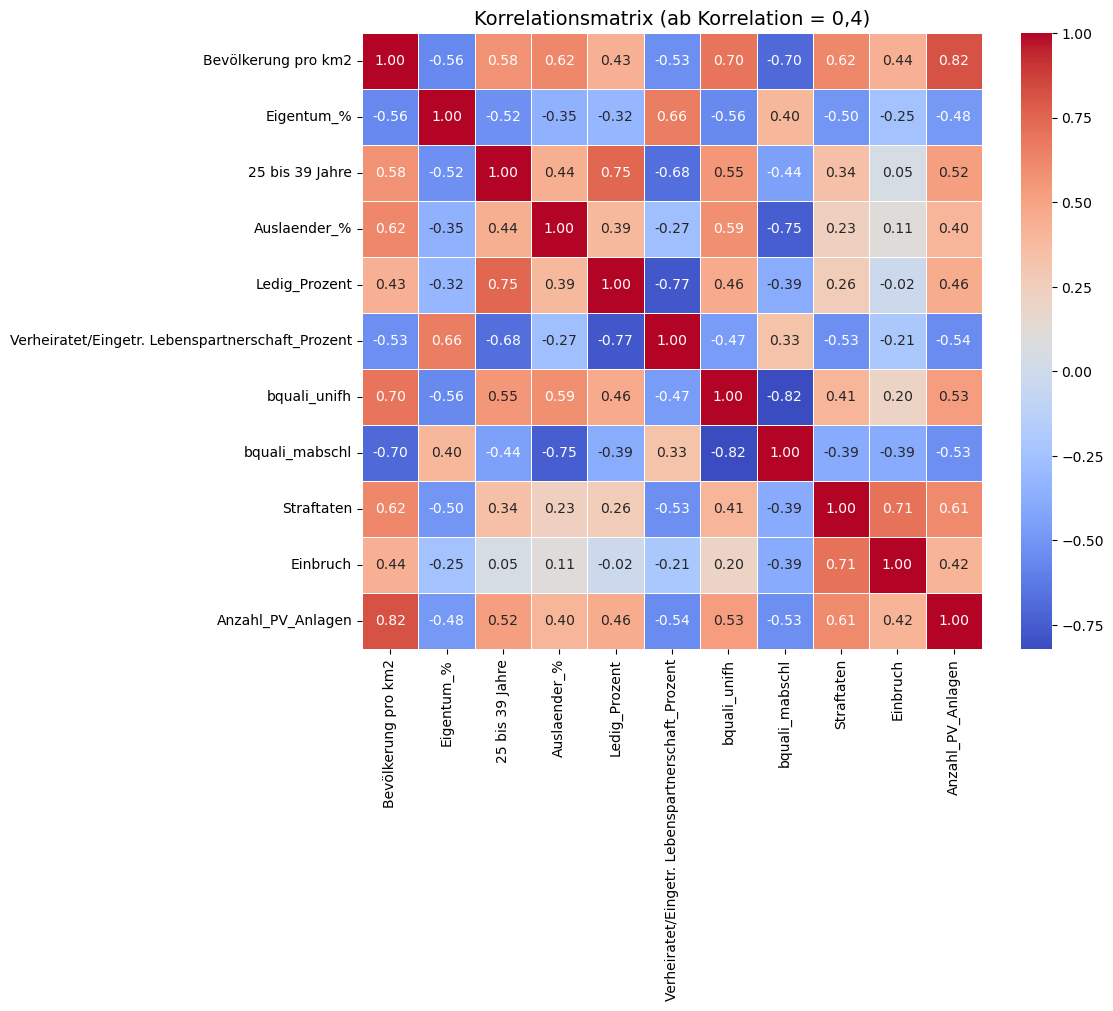

In [20]:
# Korrelationsmatrix (ab Korrelation = 0,4)
threshold = 0.4
corr = sample_df[num_vars + [target_var]].corr()
relevant_cols = corr[corr['Anzahl_PV_Anlagen'].abs() > threshold].index
# Heatmap der Korrelationsmatrix 
plt.figure(figsize=(10, 8))
sns.heatmap(corr.loc[relevant_cols, relevant_cols], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix (ab Korrelation = 0,4)', fontsize=14)
plt.show()

### Zusammenhang Bevölkerungsdichte > Anzahl PV-Anlagen

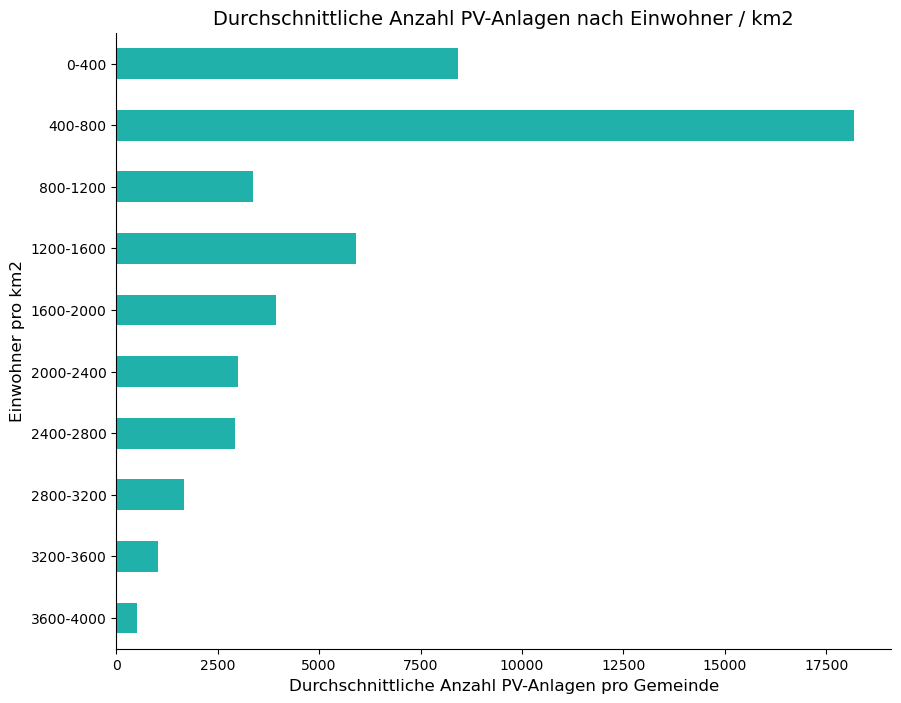

In [21]:
bin_edges = [0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800]
bins = pd.cut(sample_df['Bevölkerung pro km2'], bins=bin_edges, labels=False)

# Definiere die Bin-Grenzen und die Reihenfolge für die Bins
bin_labels = [f'{i}-{i+400}' for i in range(0, 4800, 400)]
bin_labels = bin_labels[::-1]  # Invertiere die Reihenfolge der Beschriftungen

# Weise die Bin-Grenzen und die Reihenfolge zu
sample_df['Bevölkerung pro km2 Bins'] = bins

bev_dichte = sample_df.groupby('Bevölkerung pro km2 Bins')['Anzahl_PV_Anlagen'].mean()

plt.figure(figsize=(10, 8))
bev_dichte.plot(kind='barh', color='lightseagreen')
plt.xlabel('Durchschnittliche Anzahl PV-Anlagen pro Gemeinde', fontsize=12)
plt.ylabel('Einwohner pro km2', fontsize=12)
plt.title('Durchschnittliche Anzahl PV-Anlagen nach Einwohner / km2', fontsize=14)

positions = range(len(bev_dichte))
labels = bin_labels[-len(bev_dichte):]
plt.yticks(positions, labels)
plt.show()
# Quelle: ChatGPT (siehe Protokoll ChatGPT, Seite 6-8)

### Zusammenhang Eigenheimquote > Anzahl PV-Anlagen

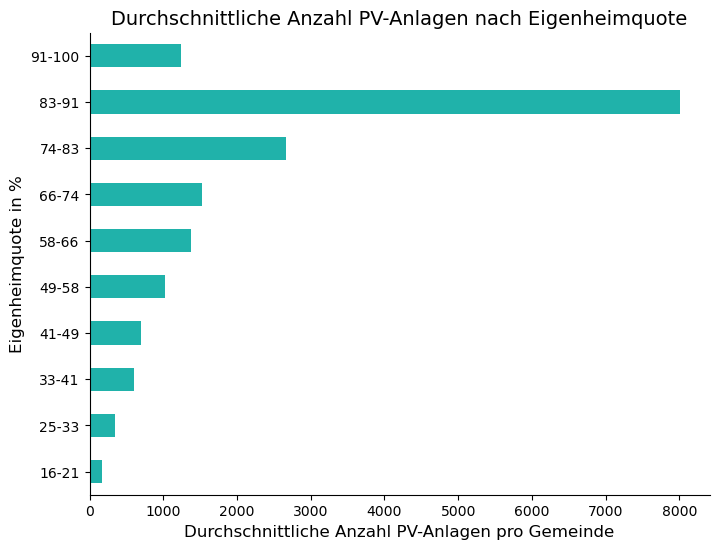

In [22]:
bins = pd.cut(sample_df['Eigentum_%'], bins=10, labels=False)
sample_df['Eigentum_% Bins'] = bins

eigenheimquote = sample_df.groupby('Eigentum_% Bins')['Anzahl_PV_Anlagen'].mean()
eigenheimquote = eigenheimquote.sort_index(ascending=False)

plt.figure(figsize=(8, 6))
eigenheimquote.plot(kind='barh', color='lightseagreen')
plt.xlabel('Durchschnittliche Anzahl PV-Anlagen pro Gemeinde', fontsize=12)
plt.ylabel('Eigenheimquote in %', fontsize=12)
plt.title('Durchschnittliche Anzahl PV-Anlagen nach Eigenheimquote', fontsize=14)

yticks = [f'{int(sample_df["Eigentum_%"].groupby(bins).min()[i])}-{int(sample_df["Eigentum_%"].groupby(bins).max()[i])}' for i in eigenheimquote.index]
yticks = yticks[::-1]  # Invertiere die Reihenfolge der Beschriftungen
plt.yticks(range(len(eigenheimquote)), yticks)

plt.show()

# Quelle: ChatGPT (siehe Protokoll ChatGPT, Seite 9-10)

### Zusammenhang Altersgruppen > Anzahl PV-Anlagen

In [23]:
selected_columns = ["Unter 3 Jahre", "3 bis 5 Jahre", "6 bis 9 Jahre", "10 bis 15 Jahre", "16 bis 18 Jahre", 
                    "19 bis 24 Jahre", "25 bis 39 Jahre", "40 bis 59 Jahre", "60 bis 66 Jahre", "67 bis 74 Jahre", 
                    "75 Jahre und älter", "Anzahl_PV_Anlagen", "AGS-8"]
alter = sample_df[selected_columns]

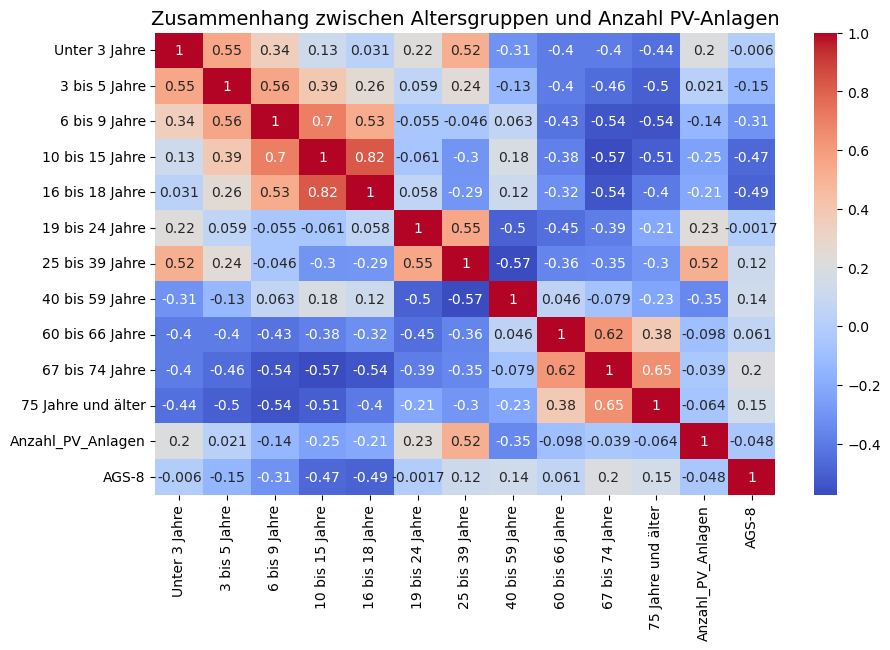

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(alter.corr(), annot=True, cmap='coolwarm')
plt.title('Zusammenhang zwischen Altersgruppen und Anzahl PV-Anlagen', fontsize=14)
plt.show()

### Zusammenhang Familienstand > Anzahl PV-Anlagen

In [25]:
selected_columns = ["Ledig_Prozent", "Verheiratet/Eingetr. Lebenspartnerschaft_Prozent",
                    "Geschieden/Eingetr. Lebenspartnerschaft aufgehoben_Prozent", 
                    "Verwitwet/Eingetr. Lebenspartner/-in verstorben_Prozent", "Ohne Angabe_Prozent",
                    "Anzahl_PV_Anlagen"]
familienstand = sample_df[selected_columns]

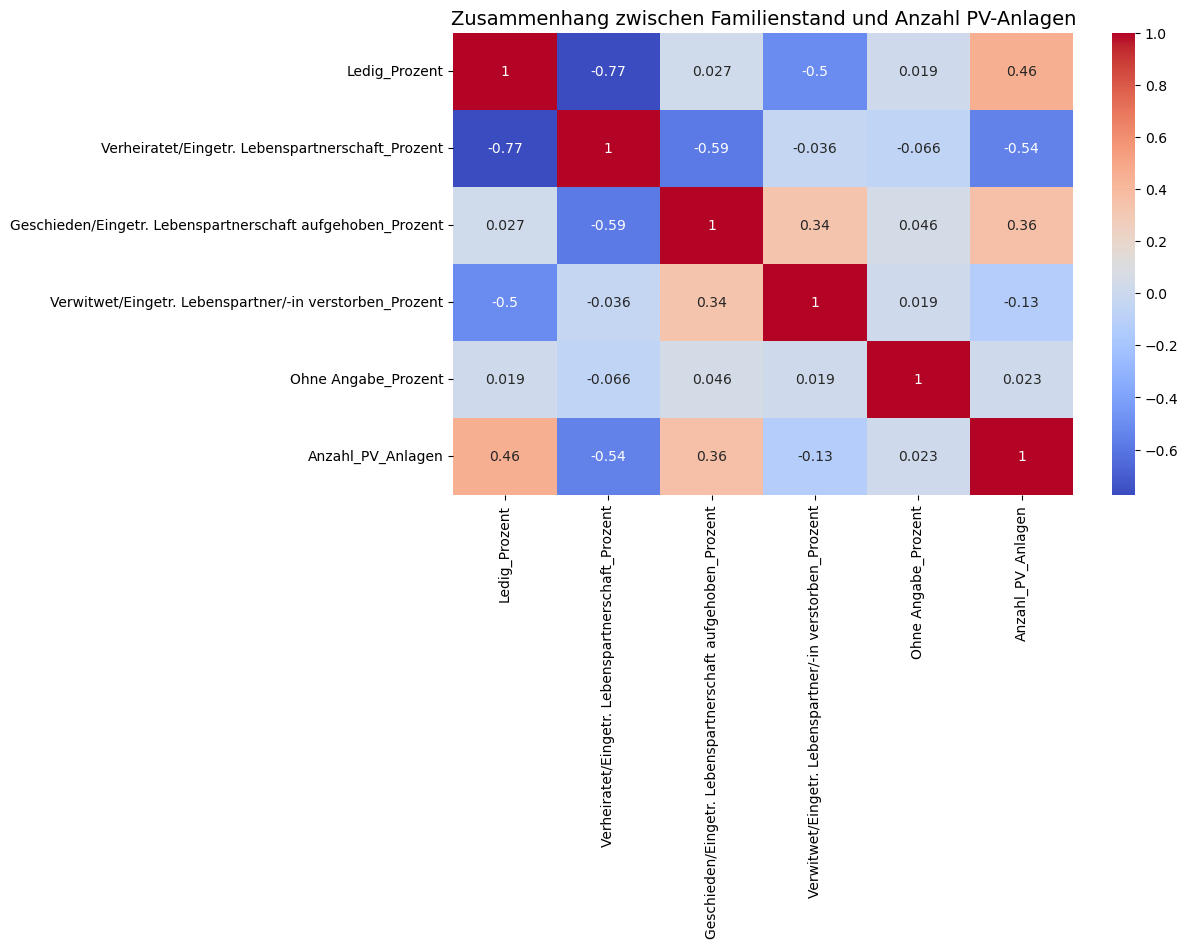

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(familienstand.corr(), annot=True, cmap='coolwarm')
plt.title('Zusammenhang zwischen Familienstand und Anzahl PV-Anlagen', fontsize=14)
plt.show()

### Zusammenhang Bildungsstand > Anzahl PV-Anlagen

In [27]:
selected_columns = ["bquali_unifh", "bquali_mabschl", "bquali_oabschl", 
                    "schule_oabschl", "Anzahl_PV_Anlagen"]
bildungsstand = sample_df[selected_columns]

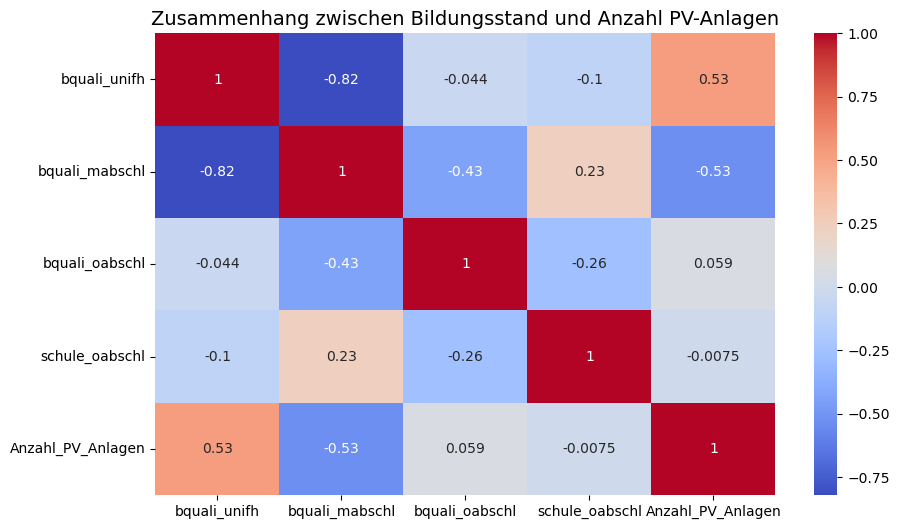

In [28]:
plt.figure(figsize=(10, 6))
sns.heatmap(bildungsstand.corr(), annot=True, cmap='coolwarm')
plt.title('Zusammenhang zwischen Bildungsstand und Anzahl PV-Anlagen', fontsize=14)
plt.show()

### Zusammenhang Straftaten > Anzahl PV-Anlagen

In [29]:
selected_columns = ["Straftaten", "Anzahl_PV_Anlagen"]
straftaten = sample_df[selected_columns]

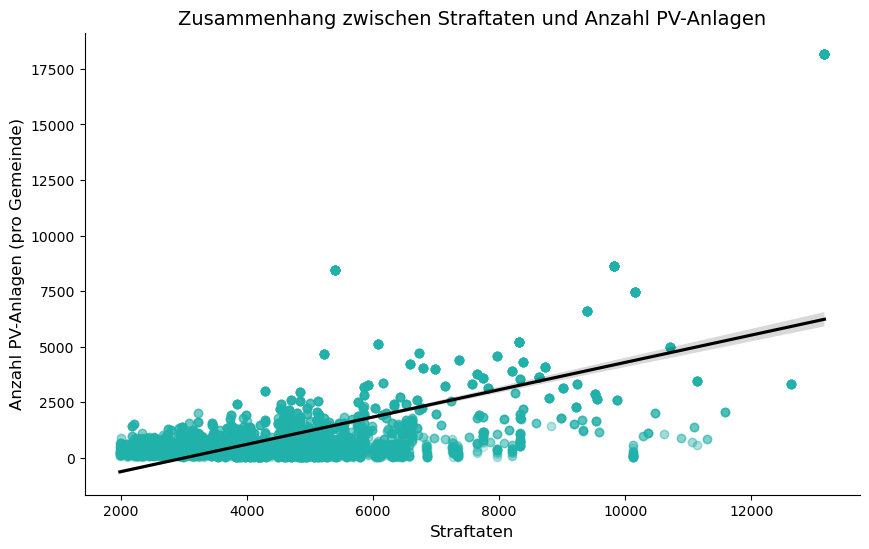

In [30]:
# Streudiagramm mit Regressionsgerade
plt.figure(figsize=(10, 6))
sns.regplot(data=straftaten, x="Straftaten", y="Anzahl_PV_Anlagen", 
            color='lightseagreen', line_kws={'color':'black'}, scatter_kws={'alpha':0.1})
plt.xlabel('Straftaten', fontsize=12)
plt.ylabel('Anzahl PV-Anlagen (pro Gemeinde)', fontsize=12)
plt.title('Zusammenhang zwischen Straftaten und Anzahl PV-Anlagen', fontsize=14)

plt.show()

In [31]:
straftaten.corr()

,Straftaten,Anzahl_PV_Anlagen
Straftaten,1.000000,0.613624
Anzahl_PV_Anlagen,0.613624,1.000000


### Zusammenhang Einbruch > Anzahl PV-Anlagen

In [32]:
selected_columns = ["Einbruch", "Anzahl_PV_Anlagen"]
einbruch = sample_df[selected_columns]

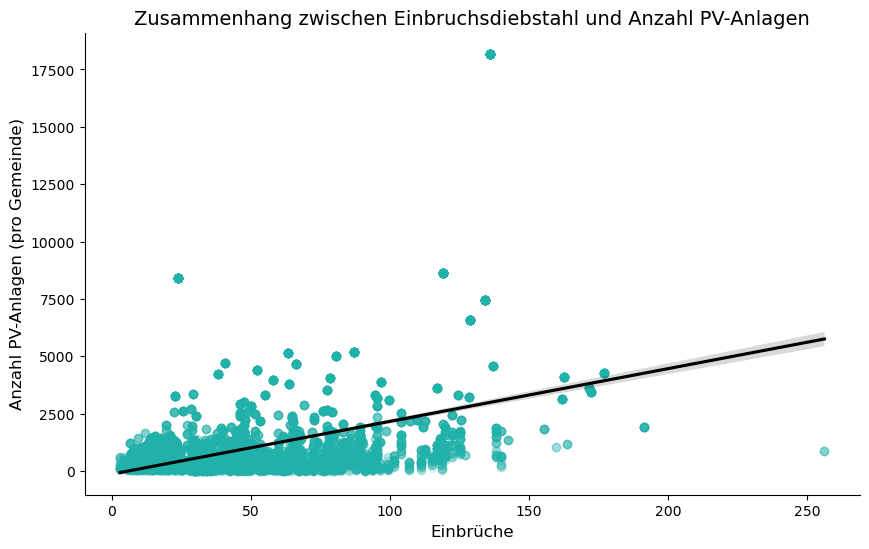

In [33]:
# Streudiagramm mit Regressionsgerade
plt.figure(figsize=(10, 6))
sns.regplot(data=einbruch, x="Einbruch", y="Anzahl_PV_Anlagen", 
            color='lightseagreen', line_kws={'color':'black'}, scatter_kws={'alpha':0.1})
plt.xlabel('Einbrüche', fontsize=12)
plt.ylabel('Anzahl PV-Anlagen (pro Gemeinde)', fontsize=12)
plt.title('Zusammenhang zwischen Einbruchsdiebstahl und Anzahl PV-Anlagen', fontsize=14)

plt.show()

In [34]:
einbruch.corr()

,Einbruch,Anzahl_PV_Anlagen
Einbruch,1.000000,0.416719
Anzahl_PV_Anlagen,0.416719,1.000000


### Erkenntnisse und Schlussfolgerungen

 **Einbruchsdiebstahl** und sonstige **Straftaten** weisen eine hohe Korrelation zur Anzahl der installierten PV-Anlagen auf. Es wird vermutet, dass    dieser Zusammenhang durch Drittfaktoren, wie Besitz- oder Einkommensungleichheit hervorgerufen wird. Daher werden diese Faktoren aus der weiteren Analyse entfernt.  
    
Beim **Bildungsstand** finden wir eine mittlere positive Korrelation zwischen Menschen mit akademischem Abschluß und der Anzahl installierter PV-Anlagen, wohingegen zwischen Menschen mit abgeschlossener Berufsausbildung und der Anzahl installierter PV-Anlagen eine mittlere negative Korrelation besteht. Für Menschen ohne Schul- oder Berufsabschluss zeigt sich hingegen keine nennenwerte Korrelation. 
    
Ein ähnliches Bild zeigt sich beim **Familienstand**. Es gibt  eine mittelhohe positive Korrelation zwischen der Anzahl PV-Anlagen und ledigen   Personen und eine mittelhohe negative Korrelation zwischen der Anzahl PV-Anlagen und  verheirateten oder in einer Lebenspartnerschaft lebenden Personen.   
    
Mit einer Korrelation von 0,82 von **Bevölkerungsdichte** zu installierten PV-Anlagen ist ein klarer Zusammenhang zu sehen: In dicht besiedelten Gebieten, wie Großstädten, gibt es vergleichsweise weige PV-Anlagen. Der höchste Wert wird für dünn besiedelte Gebiete mit 442 bis 805 Einwohner pro qm erreicht.   
    
Zwischen der **Eigenheimquote** und Anzahl installierter PV-Anlagen besteht eine mittlere negative Korrelation von -0,48. 


## Decision Tree 

### Vorbereitung der Daten

In [35]:
# Zielgröße: Anzahl installierte PV-Anlagen
# Feature Selection
target_var = "Anzahl_PV_Anlagen"

num_vars = ["Bruttoleistung", "AnzahlModule", "Bevölkerung pro km2", "Eigentum_%", 
            "Gini_Index", "haushaltseink_2011", "haushaltseink_2020", 
            "Unter 3 Jahre", "3 bis 5 Jahre", "6 bis 9 Jahre", "10 bis 15 Jahre", "16 bis 18 Jahre",
            "19 bis 24 Jahre", "25 bis 39 Jahre", "40 bis 59 Jahre", "60 bis 66 Jahre", "75 Jahre und älter", 
            "Ledig_Prozent", "Verheiratet/Eingetr. Lebenspartnerschaft_Prozent",
            "bquali_unifh", "bquali_mabschl", "CDU_Prozent", "AfD_Prozent", "FDP_Prozent", "GRÜNE_Prozent", "FREIE WÄHLER_Prozent", 
            "Sonnenstunden", "eLade", "eAuto", "Wohnen_EZFH", "Wohnen_MFH", "Heizung_Erneuerbare_%"]

cat_vars = ["Einspeisungsart", "Hauptausrichtung", "Nutzungsbereich"]

In [36]:
X_train = df_train[num_vars + cat_vars]
print(X_train.shape)

(1834804, 35)


In [37]:
X_test = df_test[num_vars + cat_vars]
print(X_test.shape)

(458702, 35)


In [38]:
y_train = df_train["Anzahl_PV_Anlagen"]  


In [39]:
y_test = df_test["Anzahl_PV_Anlagen"]  

### Analysis / Decision Tree

In [40]:
categorical_features = cat_vars
numeric_features = num_vars

# Transformer-Pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# ColumnTransformer zum Kombinieren der Transformationen
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Modell mit Preprocessing-Pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier(max_depth=4))])

# Model fit
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Bruttoleistung',
                                                   'AnzahlModule',
                                                   'Bevölkerung pro km2',
                                                   'Eigentum_%', 'Gini_Index',
                                                   'haushaltseink_2011',
                                                   'haushaltseink_2020',
                                                   'Unter 3 Jahre',
                                                   '3 bis 5 Jahre',
                                                   '6 bis 9 Jahre',
                                                   '10 bis 15 Jahre',
                                                   '16 bis 18 Jahre',
                                                   '19 bis 24 Jahre',
                                                   '25 bis 39 Jahre',
                                                   '40 bis 59 Jahr...
                                                   'bquali_unifh',
                                                   'bquali_mabschl',
                                                   'CDU_Prozent', 'AfD_Prozent',
                                                   'FDP_Prozent',
                                                   'GRÜNE_Prozent',
                                                   'FREIE WÄHLER_Prozent',
                                                   'Sonnenstunden', 'eLade',
                                                   'eAuto', 'Wohnen_EZFH', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Einspeisungsart',
                                                   'Hauptausrichtung',
                                                   'Nutzungsbereich'])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [41]:
# Extrahiere die Kategorien aus dem OneHotEncoder
tree_classifier = model.named_steps['classifier']
categorical_transformer = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categories = categorical_transformer.categories_

# Erstelle die Feature-Namen für die kategorischen Features
categorical_feature_names = []
for i, feature in enumerate(cat_vars):
    for category in categories[i]:
        categorical_feature_names.append(f"{feature}_{category}")

# Kombiniere die Feature-Namen der numerischen und kategorischen Features
feature_names = num_vars + categorical_feature_names

# Exportiere die Regeln
tree_rules = export_text(tree_classifier, feature_names=feature_names)
print(tree_rules)

|--- Bevölkerung pro km2 <= 4.73
|   |--- Gini_Index <= 1.50
|   |   |--- Bevölkerung pro km2 <= 3.21
|   |   |   |--- Bevölkerung pro km2 <= 2.47
|   |   |   |   |--- class: 508
|   |   |   |--- Bevölkerung pro km2 >  2.47
|   |   |   |   |--- class: 6605
|   |   |--- Bevölkerung pro km2 >  3.21
|   |   |   |--- 60 bis 66 Jahre <= -0.77
|   |   |   |   |--- class: 7449
|   |   |   |--- 60 bis 66 Jahre >  -0.77
|   |   |   |   |--- class: 4724
|   |--- Gini_Index >  1.50
|   |   |--- 75 Jahre und älter <= -0.19
|   |   |   |--- class: 8624
|   |   |--- 75 Jahre und älter >  -0.19
|   |   |   |--- Nutzungsbereich_Haushalt <= 0.50
|   |   |   |   |--- class: 205
|   |   |   |--- Nutzungsbereich_Haushalt >  0.50
|   |   |   |   |--- class: 772
|--- Bevölkerung pro km2 >  4.73
|   |--- bquali_mabschl <= -3.26
|   |   |--- class: 8430
|   |--- bquali_mabschl >  -3.26
|   |   |--- class: 18187



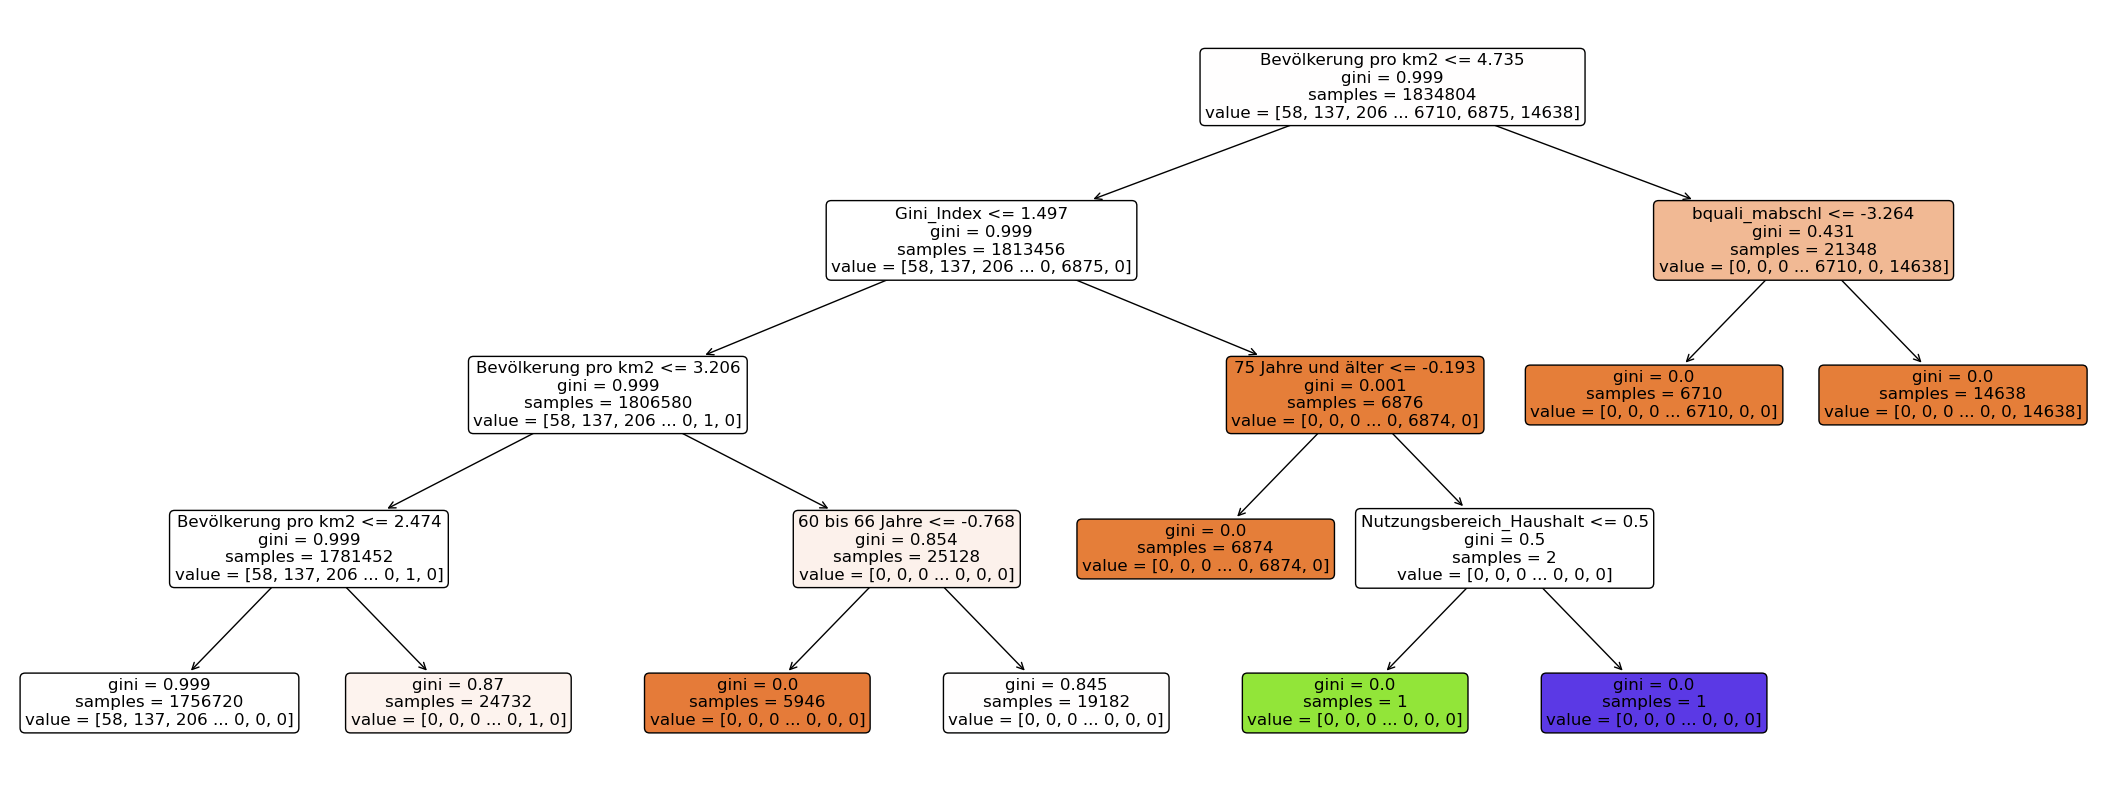

In [42]:
# Plot den Entscheidungsbaum
plt.figure(figsize=(27,10)) 
_ = tree.plot_tree(tree_classifier, feature_names=feature_names, 
             filled=True, fontsize=12, rounded = True)
plt.show()

### Feature Importance

In [43]:
feature_importance = tree_classifier.feature_importances_
feature_names = num_vars + categorical_feature_names  #Liste der Feature-Namen
feature_importance_with_names = list(zip(feature_names, feature_importance))

# Sortieren der Feature-Importance-Werte und absteigend anzeigen
feature_importance_with_names.sort(key=lambda x: x[1], reverse=True)
for feature, importance in feature_importance_with_names:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Bevölkerung pro km2, Importance: 0.4696321519785162
Feature: bquali_mabschl, Importance: 0.22910282981287988
Feature: Gini_Index, Importance: 0.1706292067104552
Feature: 60 bis 66 Jahre, Importance: 0.13053624376295864
Feature: 75 Jahre und älter, Importance: 7.467037003014926e-05
Feature: Nutzungsbereich_Haushalt, Importance: 2.4897365159894346e-05
Feature: Bruttoleistung, Importance: 0.0
Feature: AnzahlModule, Importance: 0.0
Feature: Eigentum_%, Importance: 0.0
Feature: haushaltseink_2011, Importance: 0.0
Feature: haushaltseink_2020, Importance: 0.0
Feature: Unter 3 Jahre, Importance: 0.0
Feature: 3 bis 5 Jahre, Importance: 0.0
Feature: 6 bis 9 Jahre, Importance: 0.0
Feature: 10 bis 15 Jahre, Importance: 0.0
Feature: 16 bis 18 Jahre, Importance: 0.0
Feature: 19 bis 24 Jahre, Importance: 0.0
Feature: 25 bis 39 Jahre, Importance: 0.0
Feature: 40 bis 59 Jahre, Importance: 0.0
Feature: Ledig_Prozent, Importance: 0.0
Feature: Verheiratet/Eingetr. Lebenspartnerschaft_Prozent, Imp

**Erkenntnisse:**   
  
Die Ergebnisse der Korrelationsanalyse und die Feature Importance der    
Decision Tree Analyse messen teilweise unterschiedlichen Features eine hohe    
Bedeutung bezüglich Entscheidung für eine PV-Anlage zu.   
    
Beide Analysen sehen die **Bevölkerungsdichte** als wichtigsten Einflussfaktor.   
   
Während **Bildungsniveau, Familienstand und Eigenheimquote** zentrale Features in der Korrelationsmatrix darstellen, kommen beim Decision Tree ausser dem Familienstand auch der **Gini-Index, Alterstruktur, Wahlergebnisse (CDU und FDP) und der Anteil an erneuerbaren Heizmethoden in Neubauten** als mögliche Einflussfaktoren zum Tragen.    
   
Mögliche Gründe für diese Abweichungen:   
- Nicht-lineare Beziehungen (Korrelationsanalysen basieren ausschließlich auf linearen Beziehungen zwischen den Variablen.)       
- Multikollinearität (Korrelationen zwischen den Features selbst.)    
- Modellabhängigkeit (Unterschiedliche Modelle beinhalten unterschiedliche Berechnungsgrundlagen und Gewichtungen.)   

### Score (Trainingsdaten)

In [44]:
y_train_predict = model.predict(X_train)

In [45]:
#pd.crosstab(y_train, y_train_predict)

In [46]:
model.score(X_train, y_train)

0.025993512113555453

### Score (Testdaten)

In [47]:
model.score(X_test, y_test)

0.02597546991292822

**Bewertung des Modells:**    
Der R^2 Score des Entscheidungsbaums beträgt für die Trainingsdaten 0.03202 und für die Testdaten 0.03208. Die Werte liegen sehr nah beieinander, was für eine gute Anpassung des Modells spricht.  Allerdings erklärt das Modell nur 3 Prozent der tatsächlich relevanten Einflussfaktoren und liefert damit **kein signifikantes Ergebnis**.
